In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
# Python
from pathlib import Path
import os
import warnings
import math
import datetime
import time
warnings.filterwarnings('ignore')

# TORCH
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.resnet import resnet18

# MISC
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from dotted_dict import DottedDict
import pickle

from BTwins.utils import calc_lambda
from BTwins.barlow import *
from BTwins.transform_utils import *
from csprites.datasets import ClassificationDataset
import utils
from backbone import get_backbone
from optimizer import get_optimizer

# Paper Stuff
### Lrearning Rates
Batch Size	Learning Rate
- 128  0.7
- 256  0.4
- 512  0.3
- 1024 0.25
- 2048 0.2
- 4096 0.2

In [4]:
for d in [32,64,128, 256, 512, 1024, 2048, 4096, 8192]:
    print("{:4}: {:.4f}".format(d, calc_lambda(d)))

  32: 1.3221
  64: 0.6505
 128: 0.3227
 256: 0.1607
 512: 0.0802
1024: 0.0401
2048: 0.0200
4096: 0.0100
8192: 0.0050


In [5]:
config = {
    'device': 'cuda',
    'cuda_visible_devices': '1',
    'p_data': '/mnt/data/csprites/single_csprites_64x64_n7_c32_a32_p30_s3_bg_inf_random_function_70000',
    'target_variable': 'shape',
    'batch_size': 512,
    'num_workers': 6,
    'num_epochs': 30,
    'freqs': {
        'ckpt': 50,         # epochs
        'linprob': 5,       # epochs
    },
    'num_vis': 64,
    'backbone': "FCN8i223o32",
    'backbone_args': {
        'ch_last': 32,
        'dim_in': 3,
    },
    'dim_out': 32,
    'backbone_args': {
        'ch_last': 32,
        'dim_in': 3,
    },
    'optimizer': 'adam',
    'optimizer_args': {
        'lr': 0.001,
        'weight_decay': 1e-6
    },
    'projector': [64, 64, 64],
    'scale_factor': 1,
    'p_ckpts': "ckpts",
    'p_model': "model_{}.ckpt",
    'p_stats': "stats.pkl",
    'p_config': 'config.pkl',
    'p_R_train': 'R_train.npy',
    'p_R_valid': 'R_valid.npy',
    'p_Y_valid': 'Y_valid.npy',
    'p_Y_train': 'Y_train.npy',
}
p_base = Path("/mnt/experiments/csprites") / Path(config["p_data"]).name / "tmp"
#
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d_%H-%M-%S')
#
config["p_experiment"] = str(p_base / "BTwins_bb_[{}_d]_target_[{}]_{}".format(config["backbone"],
                                                                               config["dim_out"],
                                                           config["target_variable"],
                                                                            st))
config['lambd'] = calc_lambda(config["projector"][-1])
config = DottedDict(config)
pprint.pprint(config)

{'backbone': 'FCN8i223o32',
 'backbone_args': DottedDict({'ch_last': 32, 'dim_in': 3}),
 'batch_size': 512,
 'cuda_visible_devices': '1',
 'device': 'cuda',
 'dim_out': 32,
 'freqs': DottedDict({'ckpt': 50, 'linprob': 5}),
 'lambd': 0.6505334374186833,
 'num_epochs': 30,
 'num_vis': 64,
 'num_workers': 6,
 'optimizer': 'adam',
 'optimizer_args': DottedDict({'lr': 0.001, 'weight_decay': 1e-06}),
 'p_R_train': 'R_train.npy',
 'p_R_valid': 'R_valid.npy',
 'p_Y_train': 'Y_train.npy',
 'p_Y_valid': 'Y_valid.npy',
 'p_ckpts': 'ckpts',
 'p_config': 'config.pkl',
 'p_data': '/mnt/data/csprites/single_csprites_64x64_n7_c32_a32_p30_s3_bg_inf_random_function_70000',
 'p_experiment': '/mnt/experiments/csprites/single_csprites_64x64_n7_c32_a32_p30_s3_bg_inf_random_function_70000/tmp/BTwins_bb_[FCN8i223o32_d]_target_[32]_shape',
 'p_model': 'model_{}.ckpt',
 'p_stats': 'stats.pkl',
 'projector': [64, 64, 64],
 'scale_factor': 1,
 'target_variable': 'shape'}


In [6]:
# TORCH SETTINGS
torch.backends.cudnn.benchmark = True
os.environ["CUDA_VISIBLE_DEVICES"] = config.cuda_visible_devices
device = torch.device(config.device)

# Dataset

In [7]:
p_ds_config = Path(config.p_data) / "config.pkl"

with open(p_ds_config, "rb") as file:
    ds_config = pickle.load(file)

target_variable = config.target_variable
target_idx = [idx for idx, target in enumerate(ds_config["classes"]) if target == target_variable][0]
n_classes = ds_config["n_classes"][target_variable]

In [8]:
norm_transform = utils.normalize_transform(
    ds_config["means"],
    ds_config["stds"])
inverse_norm_transform = utils.inverse_normalize_transform(
    ds_config["means"],
    ds_config["stds"]
)
target_transform = lambda x: x[target_idx]

In [13]:
# STYLE TRANSFORMATIONS
# scales
# max to min
scales_brightness = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scales_brightness = [(bs, 2 - bs) for bs in scales_brightness]

# hues
# max to min
scales_hue = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15]
scales_hue = [(-h, h) for h in scales_hue]

# contrast
scales_contrast = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scales_contrast = [(sc, 3 - 2*sc) for sc in scales_contrast]

# saturation
scales_saturation = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
scales_saturation = [(ss, 3 - 2*ss) for ss in scales_saturation]

# probabilities
p_solarise = np.linspace(0.3, 0.1, 8)
p_gaussblur = np.linspace(0.5, 0.3, 8)

# GEOMETRIC TRANSFORMATIONS
scales_rrc_scale = [(0.55, 0.85), (0.65,  0.9), (0.75, 0.95), (0.8, 1), (1, 1)]
scales_rrc_ratio = [(0.75, 1.3333), (0.75, 1.3333), (0.75, 1.3333), (0.75, 1.3333), (1, 1)]

p_flips = np.linspace(0.6, 0, 5)

num_geo_stages = len(p_flips)
num_stl_stages = len(scales_brightness)

In [16]:
print(num_geo_stages)
print(len(scales_rrc_scale))
print(len(p_solarise))

5
5
8


In [21]:
list(reversed(range(10)))

[9, 8, 7, 6, 5, 4, 3, 2, 1, 0]

In [17]:
all_stages = []
for stl_idx in range(num_stl_stages):
    for geo_idx in range(num_geo_stages):
        all_stages.append({
            'sc_brightness': scales_brightness[stl_idx],
            'sc_hue': scales_hue[stl_idx],
            'sc_contrast': scales_contrast[stl_idx],
            'sc_saturation': scales_saturation[stl_idx],
            'prob_solarize': p_solarise[stl_idx],
            'prob_gaussblur': p_gaussblur[stl_idx],
            'sc_rrc_scale': scales_rrc_scale[geo_idx],
            'sc_rrc_ratio': scales_rrc_ratio[geo_idx],
            'prob_flips': p_flips[geo_idx],
            'stl_idx': stl_idx,
            'geo_idx': geo_idx
        })

0 0


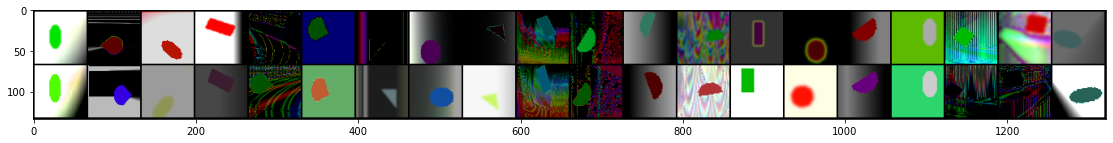

0 1


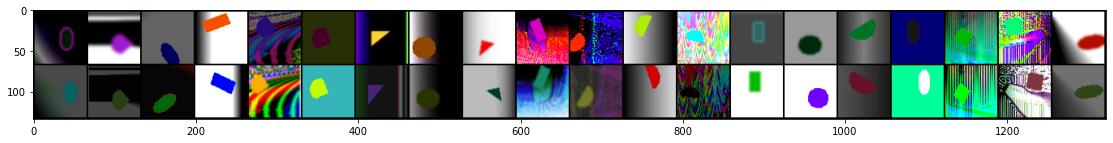

0 2


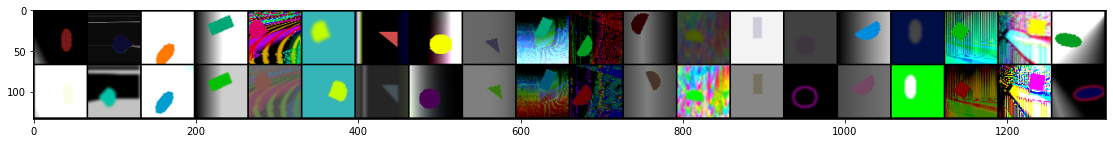

0 3


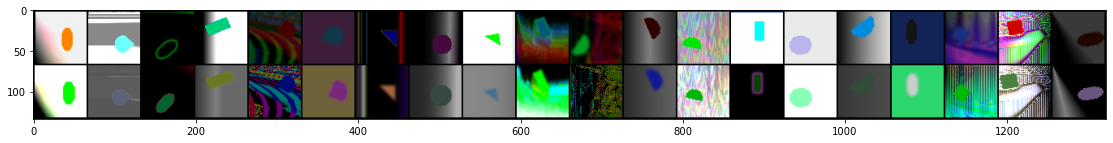

0 4


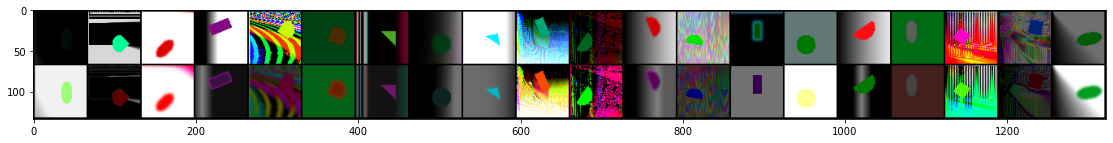

1 0


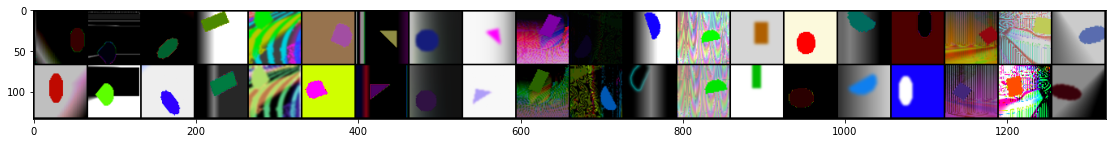

1 1


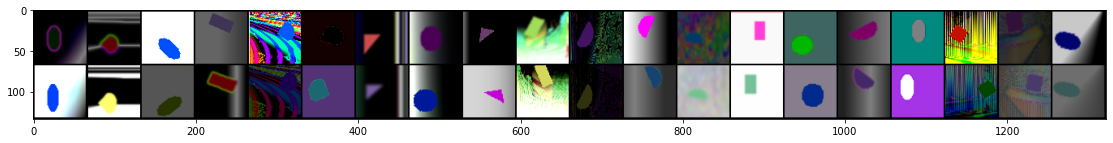

1 2


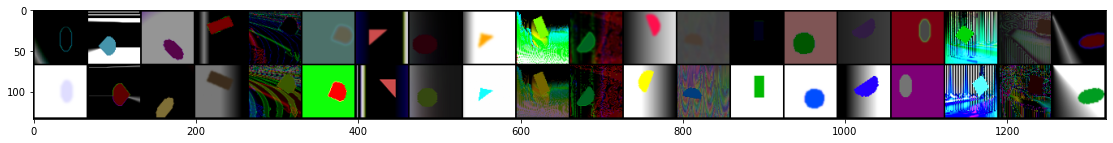

1 3


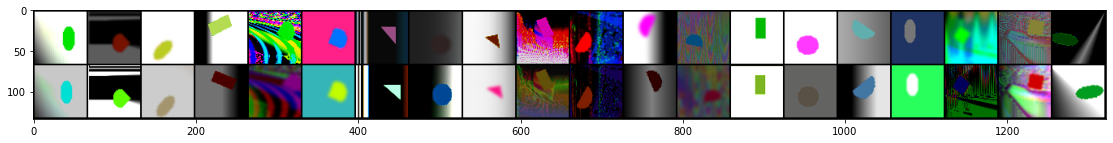

1 4


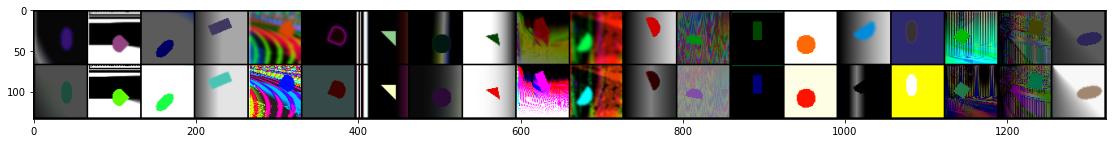

2 0


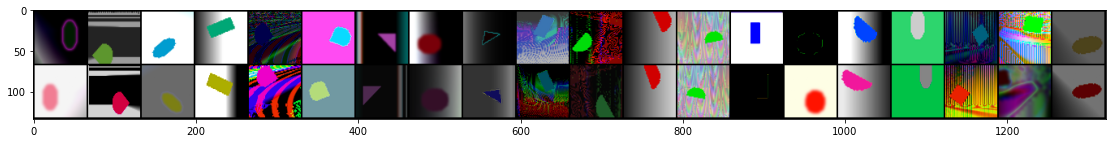

2 1


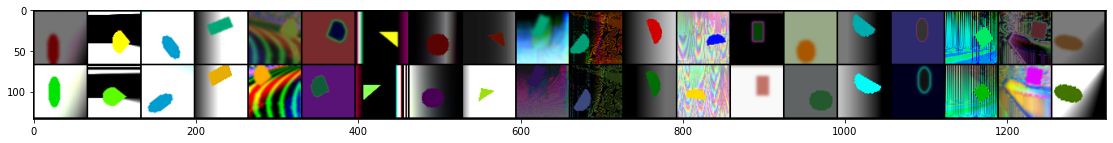

2 2


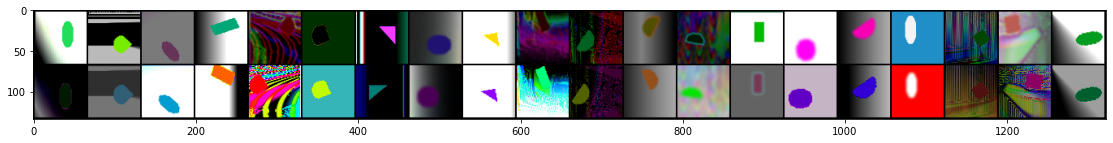

2 3


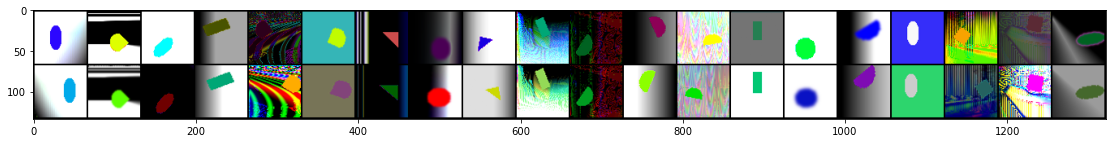

2 4


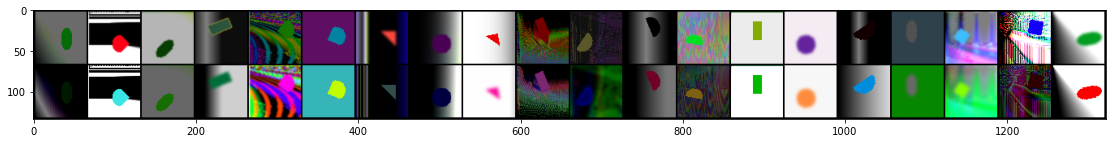

3 0


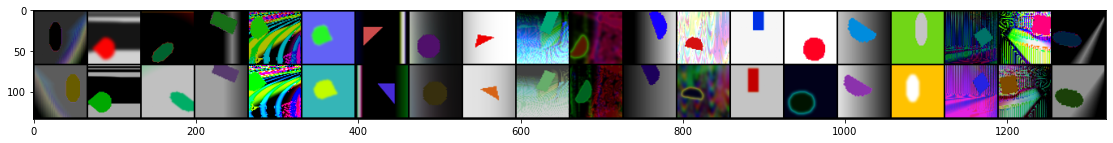

3 1


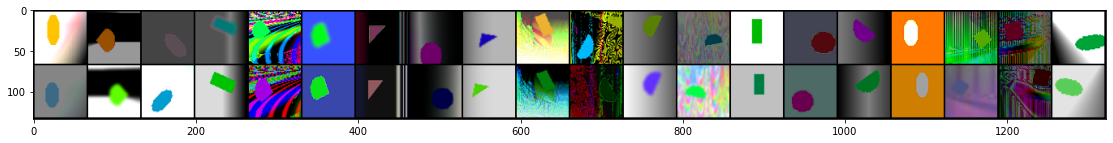

3 2


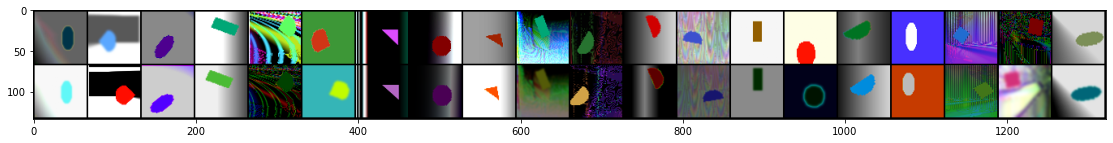

3 3


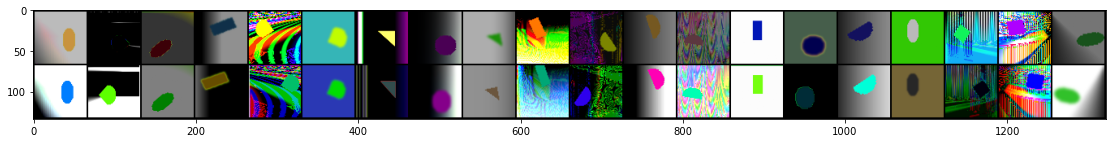

3 4


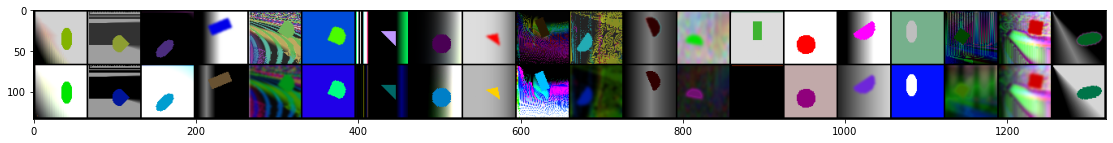

4 0


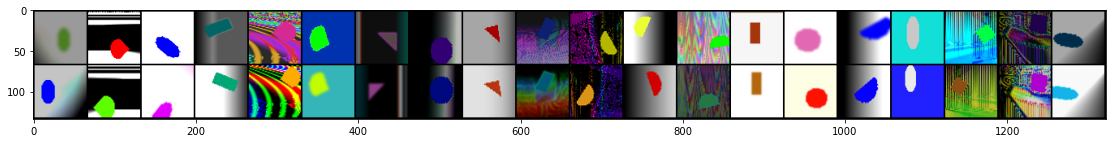

4 1


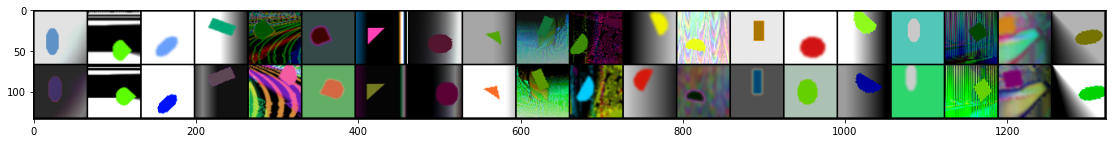

4 2


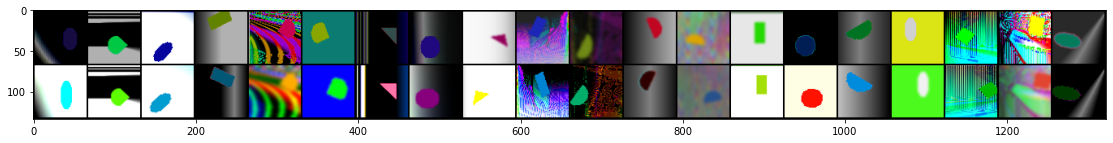

4 3


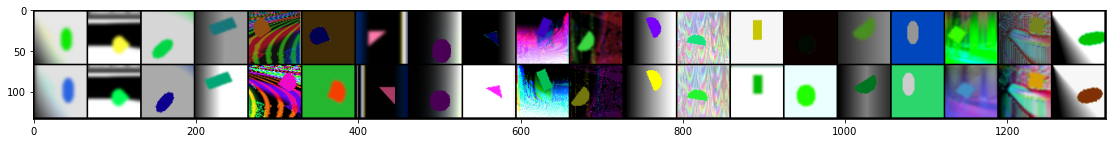

4 4


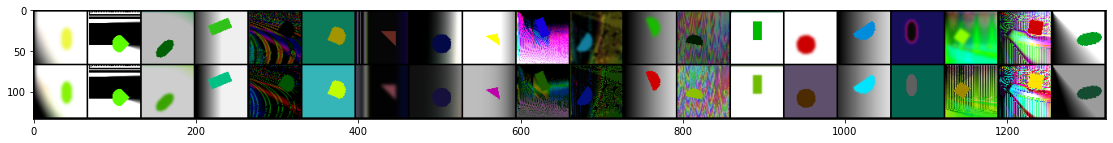

5 0


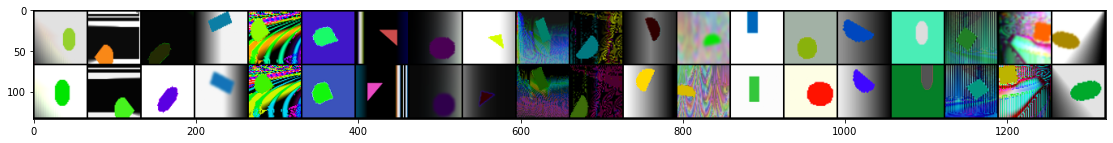

5 1


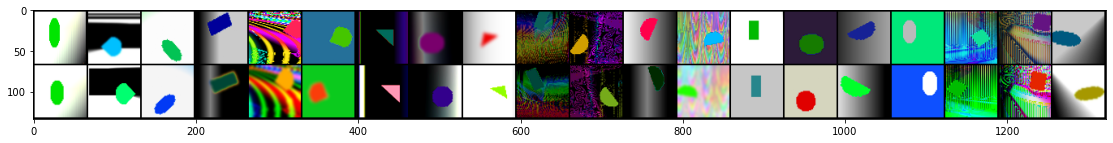

5 2


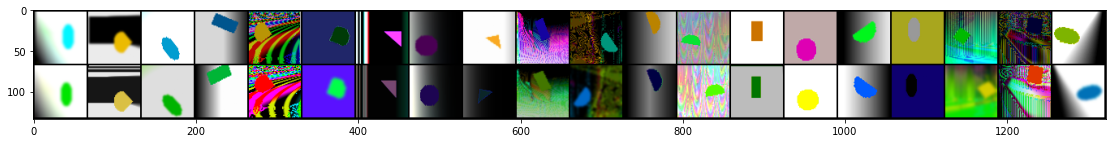

5 3


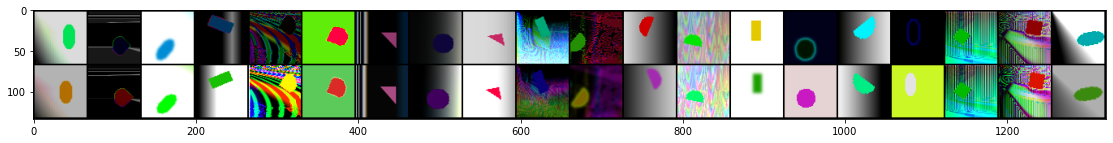

5 4


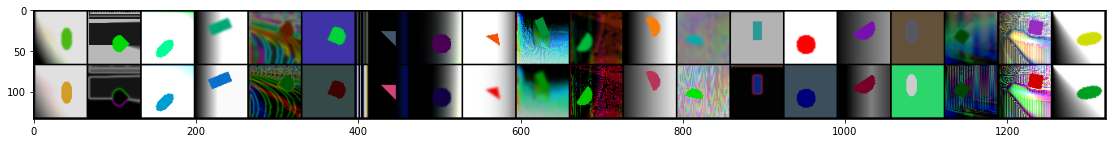

6 0


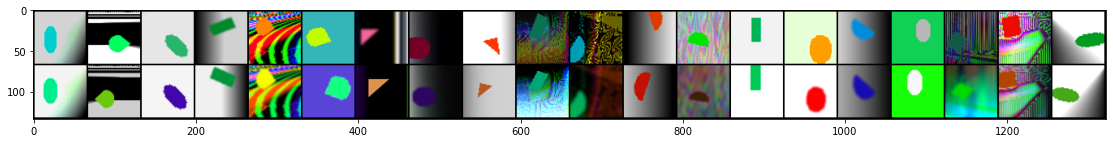

6 1


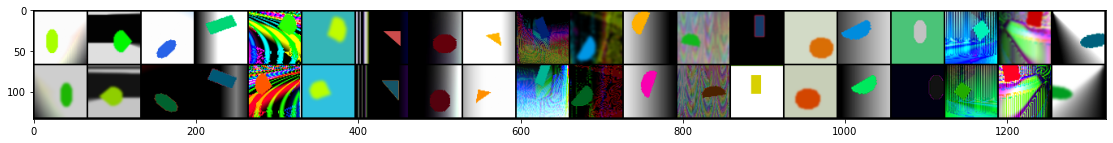

6 2


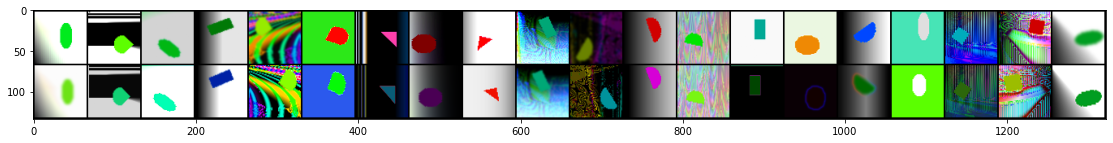

6 3


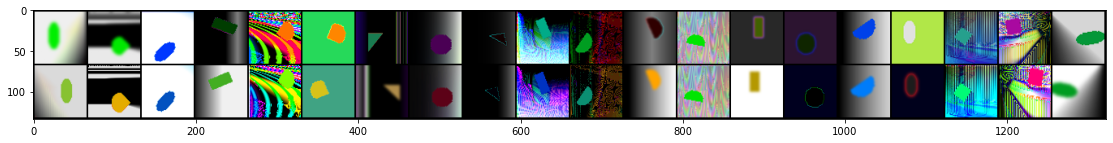

6 4


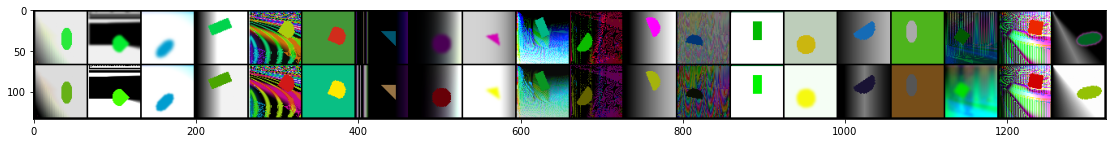

7 0


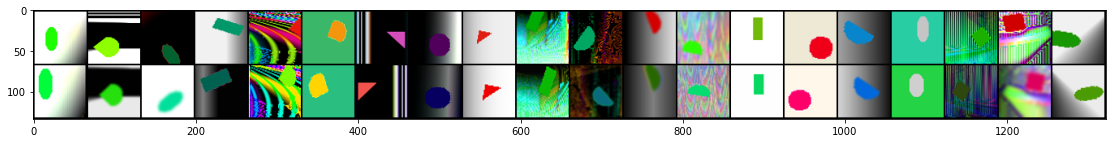

7 1


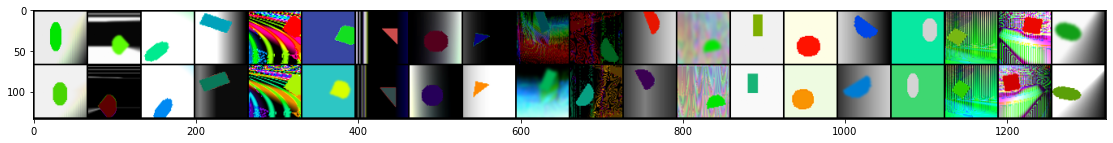

7 2


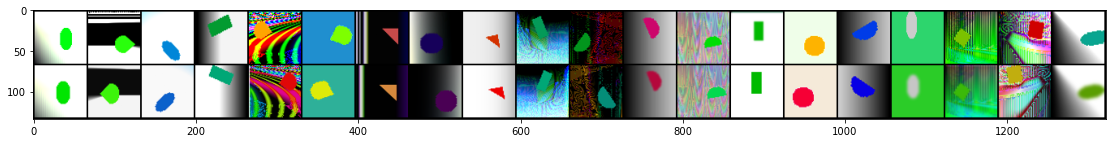

7 3


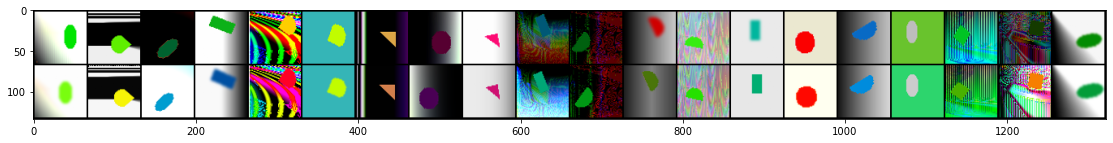

7 4


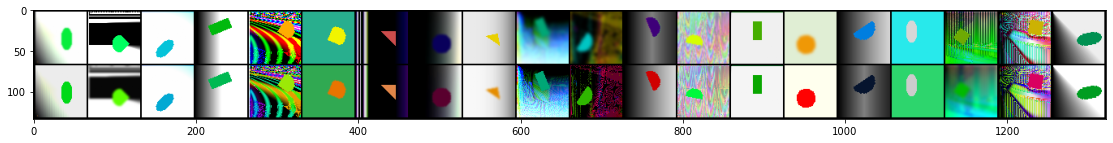

In [18]:
for transform_stage in all_stages:
    tconfig = transform_stage
    print(tconfig["stl_idx"], tconfig["geo_idx"])
    transform_train = transforms.Compose([
                        transforms.RandomResizedCrop(ds_config["img_size"],
                                                     scale=tconfig["sc_rrc_scale"],
                                                     ratio=tconfig["sc_rrc_ratio"],
                                                     interpolation=Image.BICUBIC),
                        transforms.RandomHorizontalFlip(p=tconfig["prob_flips"]),
                        transforms.RandomApply(
                            [transforms.ColorJitter(
                                brightness=tconfig["sc_brightness"],
                                contrast=tconfig["sc_contrast"],
                                saturation=tconfig["sc_saturation"],
                                hue=tconfig["sc_hue"],
                            )],
                            p=0.8
                        ),
                        GaussianBlur(p=tconfig["prob_gaussblur"]),
                        Solarization(p=tconfig["prob_solarize"]),
                        transforms.ToTensor(),
                        #norm_transform
                    ])
    ds = ClassificationDataset(
            p_data = config.p_data,
            transform=Transform(transform_train,transform_train),
            target_transform=None,
            split="train"
        )
    dl = DataLoader(
            ds,
            batch_size=128,
            shuffle=False,
            num_workers=config.num_workers,
            pin_memory=False,
            drop_last=True
        )

    n_vis = 20
    (x1,x2), _ = next(iter(dl))
    x1 = x1[:n_vis]
    x2 = x2[:n_vis]
    #
    x = torch.cat([x1,x2])
    #
    grid_img = torchvision.utils.make_grid(x, nrow=n_vis)
    plt.figure(figsize=(n_vis, 2))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

In [ ]:
torch.cat([x1,x2]).shape

In [ ]:
plt.figure(figsize=(1, 10))
plt.imshow(np.random.random((64, 64, 3)))
plt.show()
plt.close()

In [ ]:
np.random.random((32, 32, 3))

In [ ]:
geo_transform = transforms.Compose([
    transforms.RandomResizedCrop(ds_config["img_size"],
                                 scale=(1, 1),
                                 ratio=(0.75, 0.75),
                                 interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0),
                transforms.RandomVerticalFlip(p=0),
                transforms.ToTensor()
])
ds = ClassificationDataset(
        p_data = config.p_data,
        transform=Transform(geo_transform, second_transform),
        target_transform=None,
        split="train"
    )
dl = DataLoader(
        ds,
        batch_size=128,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=False,
        drop_last=True
    )

n_vis = 49
(x1, x2),_ = next(iter(dl))
x1 = x1[:n_vis]
x2 = x2[:n_vis]

grid_img = torchvision.utils.make_grid(x1, nrow=int(np.sqrt(n_vis)))
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()


In [ ]:
grid_img = torchvision.utils.make_grid(x2, nrow=int(np.sqrt(n_vis)))
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [ ]:
    stl_transform = transforms.Compose([
                    transforms.Resize(ds_config["img_size"]),
                    transforms.RandomApply(
                        [transforms.ColorJitter(brightness=(1,1),
                                                contrast=(1, 1),
                                                saturation=(1, 1),
                                                hue=(0, 0))],
                        p=1
                    ),
                    #transforms.RandomGrayscale(p=0.2),
                    #GaussianBlur(p=0.5),
                    #Solarization(p=0.2),
                    transforms.ToTensor()
    ])


    ds = ClassificationDataset(
        p_data = config.p_data,
        transform=Transform(stl_transform, second_transform),
        target_transform=target_transform,
        split="train"
    )
    dl = DataLoader(
        ds,
        batch_size=256,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=False,
        drop_last=True
    )

    n_vis = 36
    (x1, x2),_ = next(iter(dl))
    x1 = x1[:n_vis]
    x2 = x2[:n_vis]

    grid_img = torchvision.utils.make_grid(x1, nrow=int(np.sqrt(n_vis)))
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

    grid_img = torchvision.utils.make_grid(x2, nrow=int(np.sqrt(n_vis)))
    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

In [ ]:
stl_transforms = transforms.Compose([
                #transforms.Resize(ds_config["img_size"]),
                transforms.RandomResizedCrop(ds_config["img_size"],
                                             scale=(0.6, 1.0),
                                             ratio=(1, 1),
                                             interpolation=Image.BICUBIC),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomApply(
                    [transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                            saturation=0.2, hue=0.1)],
                    p=0.8
                ),
                transforms.RandomGrayscale(p=0.2),
                GaussianBlur(p=1.0),
                Solarization(p=0.0),
                transforms.ToTensor(),
            ])

In [ ]:
# TRAIN
ds_train = ClassificationDataset(
    p_data = config.p_data,
    transform=Transform(transform_train, transform_train_prime),
    target_transform=target_transform,
    split="train"
)
dl_train = DataLoader(
    ds_train,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=False,
    drop_last=True
)
# LINPROB
ds_linprob = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=target_transform,
    split="valid"
)
dl_linprob = DataLoader(
    ds_linprob,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.num_workers,
    pin_memory=False
)

# Visualize Data

In [ ]:
n_vis = config.num_vis

In [ ]:
# dl_train
(x1, x2),_ = next(iter(dl_train))
x1 = x1[:n_vis]
x2 = x2[:n_vis]
#
x1 = inverse_norm_transform(x1)
x2 = inverse_norm_transform(x2)
#
grid_img = torchvision.utils.make_grid(x1, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

grid_img = torchvision.utils.make_grid(x2, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

(x1 - x2).sum()

In [ ]:
# dl_linprob_train
x,y = next(iter(dl_linprob))
x = x[:n_vis]
y = y[:n_vis]
#
x = inverse_norm_transform(x)
#
grid_img = torchvision.utils.make_grid(x, nrow=int(np.sqrt(n_vis)))
plt.imshow(grid_img.permute(1, 2, 0))
#
y = [ds_config["class_maps"]["shape"][idx.item()] for idx in y]
print(y)

# Model

In [ ]:
model = BarlowTwins(get_backbone(config.backbone, **config.backbone_args),
                    config.projector,
                    config.lambd,
                    config.scale_factor)
#
if torch.cuda.device_count() > 1 and device != "cpu":
    print("Using {} gpus!".format(torch.cuda.device_count()))
    model = torch.nn.DataParallel(model)
    model.backbone = model.module.backbone
elif device != "cpu":
    print("Using 1 GPU!")
else:
    print("Using CPU!")
model = model.to(device)

In [ ]:
model

In [ ]:
optimizer = get_optimizer(config.optimizer, model.parameters(), config.optimizer_args)

In [ ]:
stats = {
    'train': {
        'loss': [],
        'epoch': [],
    },
    'linprob': {
        'linacc': [],
        'knnacc': [],
        'epoch': [],
    }
}
stats = DottedDict(stats)
#
p_experiment = Path(config.p_experiment)
p_experiment.mkdir(exist_ok=True, parents=True)
p_ckpts = p_experiment / config.p_ckpts
p_ckpts.mkdir(exist_ok=True)

In [ ]:
config.p_experiment

In [ ]:
global_step = 0
for epoch_idx in range(1, config.num_epochs + 1, 1):
    ################
    # TRAIN
    ################
    model.train()
    epoch_step = 0
    epoch_loss = 0
   
    desc = "Epoch [{:3}/{:3}] {}:".format(epoch_idx, config.num_epochs, 'train')
    pbar = tqdm(dl_train, bar_format= desc + '{bar:10}{r_bar}{bar:-10b}')
    #
    for (x1, x2), _ in pbar:
        x1 = x1.to(device)
        x2 = x2.to(device)
        for param in model.parameters():
            param.grad = None
        loss, on_diag, off_diag = model.forward(x1, x2, return_all=True)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_step += 1
        global_step += 1
        #
        pbar.set_postfix({'loss': loss.item(), "on_diag": on_diag.item(), "off_diag": off_diag.item()})

    stats.train.loss.append(epoch_loss / epoch_step)
    stats.train.epoch.append(epoch_idx)

    ################
    # Linprob
    ################
    if epoch_idx % config.freqs.linprob == 0 or epoch_idx == config.num_epochs:
        model.eval()
        linacc, knnacc = utils.linprob_model(model.backbone, dl_linprob, device)
        print("    Linprob Eval @LR: {:.2f} @KNN: {:.2f}".format(linacc, knnacc))
        stats.linprob.epoch.append(epoch_idx)
        stats.linprob.knnacc.append(knnacc)
        stats.linprob.linacc.append(linacc)
        model.train()
    # Checkpoint
    if epoch_idx % config.freqs.ckpt == 0 or epoch_idx == config.num_epochs:
        print("save model!")
        if torch.cuda.device_count() > 1 and device != "cpu":
            torch.save(model.module.state_dict(), p_ckpts / config.p_model.format(epoch_idx))
        else:
            torch.save(model.state_dict(), p_ckpts / config.p_model.format(epoch_idx))

# Plot 

In [ ]:
# plot losses
plt.plot(stats.train.epoch, stats.train.loss, label="train")
plt.legend()
plt.savefig(p_experiment / "barlow_loss.png")
plt.show()


# plot linprob loss
#plt.plot(stats.linprob.epoch, stats.linprob.loss, label="train")
#plt.legend()
#plt.savefig(p_experiment / "linprob_loss.png")
#plt.show()

# plot linprob acc
plt.plot(stats.linprob.epoch, stats.linprob.knnacc, label="knn")
plt.plot(stats.linprob.epoch, stats.linprob.linacc, label="lin")
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1])
plt.legend()
plt.savefig(p_experiment / "linprob_acc.png")
plt.show()

# Save stats and config

In [ ]:
with open(p_experiment / config.p_config, "wb") as file:
    pickle.dump(config, file)
with open(p_experiment / config.p_stats, "wb") as file:
    pickle.dump(stats, file)

# Get Representations 

In [ ]:
p_R_train = p_experiment / config["p_R_train"]
p_Y_train = p_experiment / config["p_Y_train"]
p_R_valid = p_experiment / config["p_R_valid"]
p_Y_valid = p_experiment / config["p_Y_valid"]

In [ ]:
# TRAIN
ds_train = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=None,
    split="train"
)
dl_train = DataLoader(
    ds_train,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=False,
    drop_last=True
)
# LINPROB
ds_valid = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=None,
    split="valid"
)
dl_valid = DataLoader(
    ds_valid,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers = config.num_workers,
    pin_memory=False
)

In [ ]:
model.eval()
R_train, Y_train = utils.get_representations(model.backbone, dl_train, device)
R_valid, Y_valid = utils.get_representations(model.backbone, dl_train, device)
#
np.save(p_R_train, R_train)
np.save(p_Y_train, Y_train)
np.save(p_R_valid, R_valid)
np.save(p_Y_valid, Y_valid)

# Get Representations

In [ ]:
# EVAL with all Features
ds_eval_train = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=None,
    split="train"
)
dl_eval_train = DataLoader(
    ds_eval_train,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.num_workers,
    pin_memory=False
)
ds_eval_valid = ClassificationDataset(
    p_data = config.p_data,
    transform=transform_linprob,
    target_transform=None,
    split="valid"
)
dl_eval_valid = DataLoader(
    ds_eval_valid,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers = config.num_workers,
    pin_memory=False
)

In [ ]:
def get_representation(x):
    return model.projector(model.backbone(x))

In [ ]:
R_train, Y_train = utils.get_representations(get_representation, dl_eval_train, device, imgs=False)
print(R_train.shape, Y_train.shape)

In [ ]:
R_valid, Y_valid, X_valid = utils.get_representations(get_representation, dl_eval_valid, device, imgs=True, inverse_norm_transform=inverse_norm_transform)
print(R_valid.shape, Y_valid.shape, X_valid.shape)

# DISTS

In [ ]:
R = R_valid
plt.bar(range(R.shape[1]), R.mean(axis=0), width=1)
plt.title("Feature Mean")
plt.savefig(p_experiment / "feature_dist_valid.png")
plt.show()

plt.bar(range(R.shape[0]), R.mean(axis=1), width=1)
plt.title("Sample Mean")
plt.savefig(p_experiment / "sample_dist_valid.png")
plt.show()

# Class Distributions on features

In [ ]:
n_plot = 100
idcs = np.random.choice(R_valid.shape[0], size=n_plot, replace=False)
#
R_plot = R_valid[idcs]
Y_plot = Y_valid[idcs]
#
dim_featuers = R_plot.shape[1]
num_targets = Y_plot.shape[1]
scale = 4
figsize = (num_targets * scale, dim_featuers)
fig, axes = plt.subplots(1, num_targets, figsize=figsize)
for col_idx in range(num_targets):
    ax = axes[col_idx]
    ax.set_title(ds_config["classes"][col_idx])
    for row_idx in range(dim_featuers):
        # reps
        r = R_plot[:, row_idx]
        r = (r - r.min()) / (r - r.min()).max()
        # targets
        y = Y_plot[:,col_idx]
        xx = np.ones(len(r)) * row_idx
        #
        ax.scatter(r, xx, c=y, cmap="turbo")
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        #ax.set_ylim([0.95, 1.05])
plt.savefig(p_experiment / "class_distribution.png")
plt.tight_layout()
plt.show()

# Predict Classes from Featuers

In [ ]:
results = []
for target_idx in range(Y_valid.shape[1]):
    target = ds_config["classes"][target_idx]
    if len(set(Y_train[:, target_idx])) == 1:
        print("{:>15}: acc = NA".format(target))
        results.append(np.inf)
        continue
    clf = LogisticRegression(random_state=0).fit(R_train, Y_train[:, target_idx])
    score = clf.score(R_valid, Y_valid[:, target_idx])
    target = ds_config["classes"][target_idx]
    print("{:>15}: acc = {:.2f}".format(target, score))
    results.append(score)

fig, ax = plt.subplots(1, 1)
ax.bar(range(len(results)), results, width=1)
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(len(ds_config["classes"])))
ax.set_xticklabels(ds_config["classes"])
plt.title("Prediction Accurace LR on valid")
plt.savefig(p_experiment / "score_lr.png")

# Visualize Latent Dimensions

In [ ]:
R = R_valid
X = X_valid
Y = Y_valid
#
n_imgs = 50
topic_idcs = []
for dim_idx in range(R.shape[1]):
    r = R[:, dim_idx]
    idcs = np.argsort(r)[-n_imgs:]
    topic_idcs.append(idcs)
topic_idcs = np.array(topic_idcs)

In [ ]:
h, w = np.array(topic_idcs.shape) * 64
img = np.zeros((h, w, 3))
print(img.shape)
n_rows, n_cols = topic_idcs.shape
for row_idx in range(n_rows):
    for col_idx in range(n_cols):
        img_idx = topic_idcs[row_idx][col_idx]
        img[row_idx * 64: row_idx * 64 + 64, col_idx * 64:col_idx * 64 + 64,:] = X[img_idx]

In [ ]:
plt.figure(figsize=topic_idcs.shape)
plt.imshow(img)
Image.fromarray(np.uint8(img * 255)).save(p_experiment / "feature_dims_highest.png")
plt.show()